<a href="https://colab.research.google.com/github/VinayakG2002/NLPlay-with-Transformers/blob/main/BERT_in_large_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers

     |████████████████████████████████| 2.5MB 8.1MB/s 
     |████████████████████████████████| 901kB 56.8MB/s 
     |████████████████████████████████| 3.3MB 22.8MB/s 


In [2]:
pip install datasets

     |████████████████████████████████| 266kB 7.5MB/s 
     |████████████████████████████████| 245kB 15.0MB/s 
     |████████████████████████████████| 122kB 13.4MB/s 


In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

In [4]:
url='https://raw.githubusercontent.com/VinayakG2002/NLPlay-with-Transformers/main/IMDB%20Dataset.csv?token=ATKA2LIXPHWLGQT64HBC2KLA6XEPW'
df = pd.read_csv(url)

In [5]:
def remove_tags(text):
    final = ""
    stt = True
    for char in text:
        if char == '<':
            stt = False
        if(stt):
            final = final + char
        if char == '>':
            stt = True
            final = final + ' '
    return final

df['text'] = df['review'].apply(remove_tags)

In [6]:
df = df.drop('review',axis = 1)

In [7]:
df['label'] = [ 1*(sent=='positive') for sent in df['sentiment']]

df = df.drop('sentiment', axis = 1)

In [8]:
df.head(10)

,text,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming t...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


In [9]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

In [10]:

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

In [11]:
small_train_dataset = dataset.shuffle(seed=42).select(range(2000))
small_eval_dataset = dataset.shuffle(seed=42).select(range(2000,4000))

In [12]:
train_range = [i for i in range(0,50000) if 6>=i%10 and i%10>=0]
eval_range = [i for i in range(0,50000) if 9>=i%10 and i%10>=7]

train_dataset = dataset.select(train_range).shuffle(seed=42)
eval_dataset = dataset.select(eval_range) .shuffle(seed=42)

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=4)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=4)

In [14]:
from transformers import AutoModel
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [16]:
class Classifier(nn.Module):
  def __init__(self,hidden_dim,output_size):
    super(Classifier,self).__init__()

    self.model = AutoModel.from_pretrained("bert-large-uncased", num_labels=2)
  
    self.LF1 = nn.Linear(1024,hidden_dim)
    self.NLF1 = nn.ReLU()

    self.LF2 = nn.Linear(hidden_dim,hidden_dim)
    self.NLF2 = nn.ReLU()

    self.LF3 = nn.Linear(hidden_dim,output_size)

  def ready_train(self):
    (self.model).train()
  
  def ready_eval(self):
    self.model.eval()

  def forward(self,x):
    out = self.model(**x)[1]

    out = self.LF1(out)
    out = self.NLF1(out)

    out = self.LF2(out)
    out = self.NLF2(out)

    out = self.LF3(out)

    return F.softmax(out,dim=1)

In [17]:
from tqdm.auto import tqdm

def train_classifier(num_epochs,train_dataloader,optimizer,classifier, loss_function = nn.CrossEntropyLoss()):
  losses = []
  num_training_steps = num_epochs*len(train_dataloader)
  progress_bar = tqdm(range(num_training_steps))
  classifier.ready_train()
  i = 0
  avg_loss = 0.
  for epoch in range(num_epochs):
    for batch in train_dataloader:
      # forward prop
      inp = tokenizer(batch['text'],padding=True, truncation=True,max_length=512, return_tensors="pt")
      inp = inp.to(device)
      out = classifier(inp)
      pred = batch['label']
      pred = pred.to(device)
      loss = loss_function(out, pred)

      # backward prop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())
      progress_bar.update(1)
      if i%100 == 0  and i//100>=1:
        print(avg_loss/100)
        avg_loss = 0
      i+=1
      avg_loss = avg_loss + float(loss.item())
  return losses

In [18]:

def plot_loss(losses):
  x = [i for i in range(0,len(losses))]
  plt.plot(x,losses)
  plt.title('Loss fnction')
  plt.ylabel('Loss')
  plt.xlabel('batch index')

def smooth_loss(losses,f):
  y = [0]*len(losses)
  for i in range(0,f):
    y[i] = (sum(losses[:i+1+f]))/(i+1+f)
  for i in range(f,len(losses)-f-1):
    y[i] = (sum(losses[i-f:i+f+1]))/(2*f+1)
  for i in range(len(losses)-f-1,len(losses)):
    y[i] = (sum(losses[i-f:]))/(len(losses)-i+f)
  plot_loss(y)

In [19]:

output_size = 2
hidden_dim = 1000

classifier = Classifier(hidden_dim,output_size)
classifier.to(device)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_

In [20]:
num_epochs = 3
lr = 1e-3
optimizer = optim.SGD(classifier.parameters(), lr)

tot_losses = train_classifier(num_epochs,train_dataloader,optimizer,classifier)

0.6930602198839187
0.6943906396627426
0.6922871720790863
0.694352707862854
0.6920868021249771
0.6916892361640931
0.6891696339845658
0.6919605261087418
0.6892067664861679
0.6852558654546738
0.6821711999177933
0.6802184218168259
0.6623841959238053
0.6399163621664047


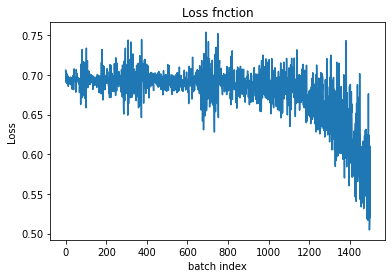

In [21]:
plot_loss(tot_losses)

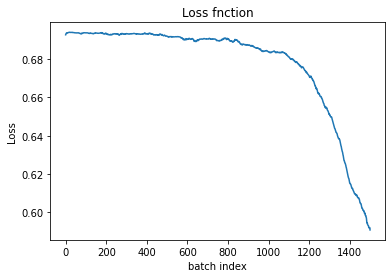

In [22]:
smooth_loss(tot_losses, 100)

In [23]:

classifier.ready_eval()
def acc(dataloader,classifier):
  corr = 0
  tot = len(dataloader)*4
  for batch in dataloader:
  # forward prop
    inp = tokenizer(batch['text'],padding=True, truncation=True,max_length=512, return_tensors="pt")
    inp = inp.to(device)
    out = list(torch.argmax(classifier(inp),dim=1))
    exp = list(batch['label'])
    
    for i,x in enumerate(out):
      if x == exp[i]:
        corr = corr+1
    
  return 100*(corr/tot)

In [24]:
acc(train_dataloader,classifier)

89.55

In [25]:

acc(eval_dataloader,classifier)

87.45

In [26]:
model_name = 'xlm-mlm-en-2048'

In [27]:
class ClassifierGen(nn.Module):
  def __init__(self,hidden_dim,output_size,model_name):
    super(ClassifierGen,self).__init__()

    self.model = AutoModel.from_pretrained(model_name, num_labels=2)
  
    self.LF1 = nn.Linear(2048,hidden_dim)
    self.NLF1 = nn.ReLU()

    self.LF2 = nn.Linear(hidden_dim,hidden_dim)
    self.NLF2 = nn.ReLU()

    self.LF3 = nn.Linear(hidden_dim,output_size)

  def ready_train(self):
    (self.model).train()
  
  def ready_eval(self):
    self.model.eval()

  def forward(self,x):
    out = self.model(**x)[1]

    out = self.LF1(out)
    out = self.NLF1(out)

    out = self.LF2(out)
    out = self.NLF2(out)

    out = self.LF3(out)

    return F.softmax(out,dim=1)

In [28]:
tokenizer = AutoTokenizer.from_pretrained(model_name)